# XPCS&XSVS Pipeline for Single-(Gi)-SAXS Run
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [5885]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

## Control Runs Here

In [5886]:
scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)

force_compress = False #True   #force to compress data 
bin_frame = False   #generally make bin_frame as False

para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = False   #run waterfall analysis
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_one_time = True  #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True #False  #False #True #True #False    #run  two-time
run_four_time = True  #False   #run  four-time
run_xsvs= False #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 6#3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name
if scat_geometry == 'gi_saxs':run_xsvs= False 
    

In [5887]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [5888]:
CYCLE = '2017_1'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir0 = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir0, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir0)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2017_1/manisen/Results/


## Load Metadata & Image Data



### Change this line to give a uid

In [6547]:
#uid = '96c5dd'  #count : 1 ['8a5346'] (scan num: 9948) (Measurement: XPCS series alpha=0.16,.1s &4.9s 100 frames )

#uid = '89297ae8'
#uid = 'a1e0fb'  #C60/graphene1 4th scan 18k frames, 10Hz, incidence angle 0.2 deg 

#uid = 'de3935'

#uid = '481000' #(scan num: 11280) (Measurement: 200fr 5ms 0.05s period T=160C )
#uid = '7a5fae' #(scan num: 11278) (Measurement: 200fr 5ms 0.05s period T=190C )
#uid = '597241'  # (scan num: 11276) (Measurement: 200fr 5ms 0s period T=190C )
#uid='dc7b2e' # (scan num: 11275) (Measurement: 200fr 1s 0s period RT T=5E-3 )
#uid ='237ef2' #(scan num: 11271) (Measurement: 200fr 5ms 2s period RT )
#uid = 'da7b8d' #(scan num: 11260) (Measurement: CoralPor 2k 100Hz )
#uid = '99fb5c' #count : 1 ['99fb5c'] (scan num: 11259) (Measurement: CoralPor 2k 100Hz )
#uid = 'af94fc'  #count : 1 ['af94fc'] (scan num: 11268) (Measurement: 2k 5ms .1s period RT )
#uid = 'c18bc9' #(scan num: 11286) (Measurement: 200fr 5ms 0.5s period T=140C )
#uid = '2a1e82' #count : 1 ['2a1e82'] (scan num: 11284) (Measurement: 200fr 5ms 0.05s period T=140C )
#uid = 'a400b5'    # (scan num: 11287) (Measurement: 200fr 5ms 0.5s period T=120C )
#uid = 'a4937e'   # (scan num: 11289) (Measurement: 200fr 5ms 2s period T=120C )
#uid = 'bb1af4'   # (scan num: 11290) (Measurement: 100fr 5ms 4s period T=120C )
#uid ='56ea89' #(scan num: 11291) (Measurement: 200fr 5ms 0.05s period T=160C )
#uid ='0e6c2a' #(scan num: 11292) (Measurement: 200fr 5ms 0s period T=160C )
#uid ='de3935' #(scan num: 11282) (Measurement: 200fr 5ms 0s period T=140C )
#uid ='b48c29' #(scan num: 11293) (Measurement: 200fr 5ms 0s period T=175C )
#uid ='352f7f' #(scan num: 11294) (Measurement: 200fr 5ms 0.05s period T=175C )
#uid ='bb2a57' #(scan num: 11295) (Measurement: 200fr 5ms 0.05s period T=175C )
#uid ='ab75f4' #(scan num: 11296) (Measurement: 200fr 5ms 0.05s period T=180C )
#uid ='db4599' #(scan num: 11298) (Measurement: 200fr 5ms 0s period T=180C )
#uid ='f81955' #(scan num: 11300) (Measurement: 200fr 5ms 4s period T=25C )
#uid ='8a7e6f' #(scan num: 11301) (Measurement: 200fr 5ms 4s period T=25C )
#uid = 'bd5e96' #count : 1 ['bd5e96'] (scan num: 11302) (Measurement: 100fr 5ms 2s period T=25C )
#uid ='8ab05f' #(scan num: 11303) (Measurement: 50fr 5ms 4s period T=25C )
#uid ='6a2261' #(scan num: 11304) (Measurement: 200fr 5ms 1s period T=190C )
#uid ='9ab339' #(scan num: 11305) (Measurement: 200fr 5ms 0.1s period T=190C )
#uid ='22fe5c' #(scan num: 11306) (Measurement: 100fr 5ms 0.2s period T=190C )
#uid ='39e754b2'#-510b-4c13-9ebb-06fe09b79579' #(scan num: 11307) (Measurement: 50fr 5ms 0.2s period T=190C )
#uid = 'c5de86' #count : 1 ['c5de86'] (scan num: 11308) (Measurement: 50fr 5ms 0.2s period T=190C )
#uid = '36b2d5'  # (scan num: 11313) (Measurement: 50fr 5ms 0.2s period T=180C )
#uid = '22f45d'   # (scan num: 11315) (Measurement: 50fr 5ms 0.4s period T=180C )
#uid ='034bcb'# (scan num: 11317) (Measurement: 50fr 5ms 0.4s period T=180C )
#uid ='034d26' #(scan num: 11316) (Measurement: 50fr 5ms 0.4s period T=180C )
#uid ='a9a02b' #(scan num: 11312) (Measurement: 50fr 5ms 0.05s period T=180C )
#uid ='c5de86' #(scan num: 11308) (Measurement: 50fr 5ms 0.2s period T=190C )
#uid ='d062b0' #(scan num: 11327) (Measurement: 50fr 5ms 0.2s period T=175C )
#uid ='1ab5ac' #(scan num: 11329) (Measurement: 50fr 5ms 0.4s period T=175C )
#uid ='2edc75' #(scan num: 11331) (Measurement: 50fr 5ms 1s period T=175C )
#uid ='1f9c9c' #(scan num: 11334) (Measurement: 50fr 5ms 2s period T=175C )
#uid = 'cd8726'   # (scan num: 11336) (Measurement: 50fr 5ms 0s period T=190 )
#uid ='bd04b7' #(scan num: 11337) (Measurement: 25fr 5ms 0s period T=190 )
#uid ='913ed9' #(scan num: 11338) (Measurement: 100fr 1.34ms 0s period T=190 )
#uid ='e7dda7' #(scan num: 11339) (Measurement: 100fr 1.34ms 0.025s period T=190 )
#uid ='f19723' #(scan num: 11340) (Measurement: 100fr 1.34ms 0.2s period T=175 )
#uid ='db5a54' #(scan num: 11341) (Measurement: 50fr 1.34ms 0.2s period T=175 )
#uid ='e3e325' #(scan num: 11342) (Measurement: 50fr 1.34ms 0.5s period T=175 )
#uid ='343e85' #(scan num: 11344) (Measurement: 75fr 1.34ms 2.5s period T=175 )
#uid ='629d75' #(scan num: 11346) (Measurement: 50fr 1.34ms 2.5s period T=175 repeat 2 )
#uid ='1cca34' #(scan num: 11352) (Measurement: 50fr 1.34ms 2.5s period T=175 repeat 1 )
#uid ='9846cb' #(scan num: 11353) (Measurement: 50fr 1.34ms 2.5s period T=175 repeat 2 )
#uid ='b57f7d' #(scan num: 11354) (Measurement: 50fr 1.34ms 2.5s period T=175 repeat 3 )
#uid ='2f781b' #(scan num: 11355) (Measurement: 50fr 1.34ms 2.5s period T=175 repeat 4 )
#uid ='8a6c63' #(scan num: 11356) (Measurement: 50fr 1.34ms .2s period T=175 )
#uid ='b5e2ec' #(scan num: 11357) (Measurement: 50fr 1.34ms .7.5s period T=175 )
#uid ='cff9b6' #(scan num: 11358) (Measurement: 50fr 1.34ms 0s period T=175 )
#uid = '5d8da8' # (scan num: 11362) (Measurement: 100fr 1.34ms 0s period T=190 radiation test )
#uid = '7ea3af'  # (scan num: 11363) (Measurement: 200fr 1.34ms 0s period T=190 radiation test )
#uid = 'e6de74'  # (scan num: 11364) (Measurement: 500fr 1.34ms 0s period T=190 radiation test )
#uid = '23e353'   # (scan num: 11365) (Measurement: 200fr 1.34ms 0s period T=190 radiation test )
#uid = '6ae485'   # (scan num: 11366) (Measurement: 200fr 1.34ms .2s period T=190 radiation test )
#uid = '40f185'   # (scan num: 11367) (Measurement: 200fr 1.34ms 1s period T=190 radiation test )
#uid ='9874fe' #(scan num: 11368) (Measurement: 200fr 1.34ms 0s period T=180 repeat: 1 )
#uid ='8a1c3b' #(scan num: 11369) (Measurement: 200fr 1.34ms 0.2s period T=180 repeat: 1 )
#uid ='173041' #(scan num: 11370) (Measurement: 200fr 1.34ms 1s period T=180 repeat: 1 )
#uid ='f0d1c5' #(scan num: 11371) (Measurement: 200fr 1.34ms 5s period T=180 repeat: 1 )
#uid ='b055f5' #(scan num: 11372) (Measurement: 500fr 1.34ms 0s period T=42 repeat: 0 )
#uid ='96724f' #(scan num: 11373) (Measurement: 500fr 1.34ms 0.05s period T=42 repeat: 0 )
#uid ='65a7b5' #(scan num: 11374) (Measurement: 500fr 1.34ms 0s period T=42 repeat: 1 )
#uid ='7af115' #(scan num: 11375) (Measurement: 500fr 1.34ms 0.05s period T=42 repeat: 1 )
#uid ='20e40b' #(scan num: 11376) (Measurement: 500fr 1.34ms 0s period T=44 repeat: 0 )
#uid ='55db36' #(scan num: 11377) (Measurement: 500fr 1.34ms 0.05s period T=44 repeat: 0 )
#uid ='bb1f0e' #(scan num: 11378) (Measurement: 500fr 1.34ms 0s period T=44 repeat: 1 )
#uid ='6b2740' #(scan num: 11380) (Measurement: 500fr 1.34ms 0s period T=190 repeat: 0 )
#uid ='547fb3' #(scan num: 11381) (Measurement: 500fr 1.34ms 0.05s period T=190 repeat: 0 )
uid ='ff656c' #(scan num: 11382) (Measurement: 500fr 1.34ms 0.2s period T=190 repeat: 0 )

In [6548]:
#start_time, stop_time = '2016-11-30  17:41:00', '2016-11-30  17:46:00'  
#sids, uids = find_uids(start_time, stop_time)

In [6549]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2017_1/manisen/Results/ff656c/


# Don't Change these lines below here

* get metadata

In [6550]:
md = get_meta_data( uid )

* get data

In [6551]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
if 'number of images'  not in list(md.keys()):
    md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

hdf5 path = /XF11ID/data/2017/01/21/09cfeae8-2ef2-4258-9c2c_68_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 500 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [6552]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

suid--> ff656c
number of images--> 500
uid--> ff656c1f-5aa3-4dcb-8489-e1809933ff1e
scan_id--> 11382
start_time--> 2017-01-21 01:01:54
stop_time--> 2017-01-21 01:03:38
sample--> dabp2vp36k44pc_new
Measurement--> 500fr 1.34ms 0.2s period T=190  repeat: 0
acquire period--> 0.2
exposure time--> 0.00134
det_distanc--> 4.89
beam_center_x--> 1404.0
beam_center_y--> 791.0


## Overwrite Some Metadata if Wrong Input

In [6553]:
inc_x0 = None
inc_y0=  None

dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )

setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

center--> [791, 1404]
lambda_--> 1.28574
exposuretime--> 0.00134
dpix--> 0.0750000035623
uid--> uid=ff656c
path--> /XF11ID/analysis/2017_1/manisen/Results/ff656c/
Ldet--> 4890.0
timeperframe--> 0.2


## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change the blow line to give mask filename

In [6554]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2016_3/masks/'
    #mask_name =  'Nov16_4M-GiSAXS_mask.npy'
    mask_name =  'Octo_11_mask.npy'
    
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2017_1/masks/'
    mask_name = 'Jan19_4M_SAXS_mask.npy'

<IPython.core.display.Javascript object>


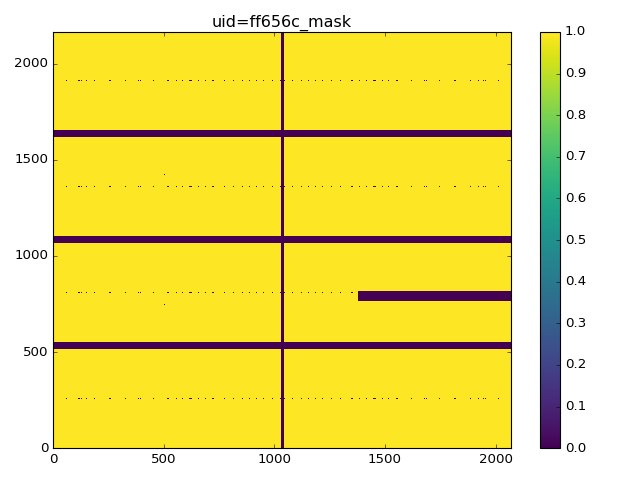

In [6555]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse=True ) 
mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Check several frames average  intensity

In [6556]:
img_choice_N = 3
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uidstr)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

<IPython.core.display.Javascript object>


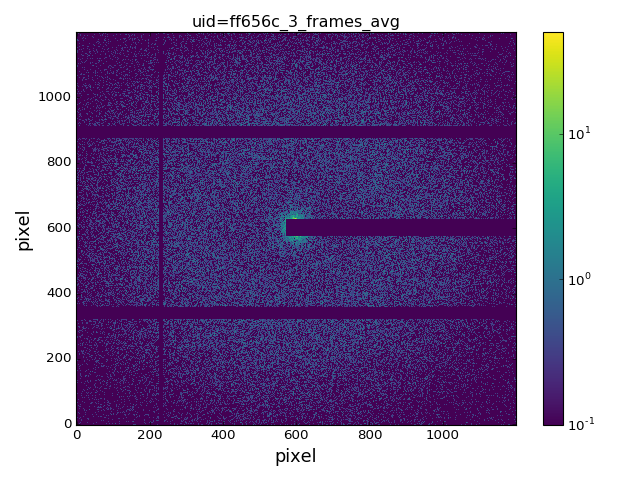

In [6557]:
if scat_geometry !='saxs':
    show_img( avg_img,  vmin=.1, vmax=np.max(avg_img*.1), logs=True,
 image_name= uidstr + '_%s_frames_avg'%img_choice_N,  save=True, path=data_dir) 
else:    
    show_saxs_qmap( avg_img, setup_pargs, width=600, show_pixel = True,
       vmin=.1, vmax= np.max(avg_img), logs=True, image_name= uidstr + '_%s_frames_avg'%img_choice_N )

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [6558]:
compress=True
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
#compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress
print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + 'Always ' + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.14678165455035902.
Will Always DO apply compress process.


In [6559]:
good_start = 0  #5  #make the good_start at least 0

In [6560]:
bin_frame = False #True # False # True  #generally make bin_frame as False

In [6561]:
if bin_frame:
    bin_frame_number=4
    timeperframe = acquisition_period * bin_frame_number
else:
    bin_frame_number =1

Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_ff656c1f-5aa3-4dcb-8489-e1809933ff1e.cmp.
Using a multiprocess to compress the data.
hdf5 path = /XF11ID/data/2017/01/21/09cfeae8-2ef2-4258-9c2c_68_master.h5
hdf5 path = /XF11ID/data/2017/01/21/09cfeae8-2ef2-4258-9c2c_68_master.h5
It will create 5 temporary files for parallel compression.
hdf5 path = /XF11ID/data/2017/01/21/09cfeae8-2ef2-4258-9c2c_68_master.h5
hdf5 path = /XF11ID/data/2017/01/21/09cfeae8-2ef2-4258-9c2c_68_master.h5
hdf5 path = /XF11ID/data/2017/01/21/09cfeae8-2ef2-4258-9c2c_68_master.h5
hdf5 path = /XF11ID/data/2017/01/21/09cfeae8-2ef2-4258-9c2c_68_master.h5
hdf5 path = /XF11ID/data/2017/01/21/09cfeae8-2ef2-4258-9c2c_68_master.h5
#####
No bad frames are involved.
Combining the seperated compressed files together...
The good_start frame number is: 0 
uid=ff656c_fra_0_500


<IPython.core.display.Javascript object>


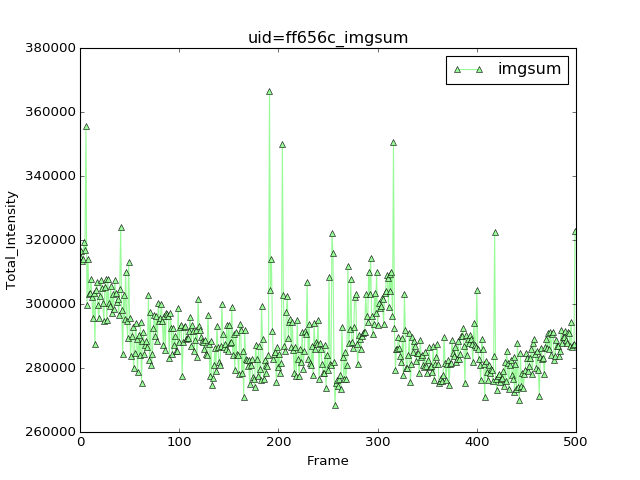

Total time: 0.31 min


In [6562]:
t0= time.time()
if bin_frame_number==1:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
else:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number) 
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= para_compress,  bad_pixel_threshold= 1e14,
                        bins=bin_frame_number, num_sub= 100, num_max_para_process= 500  )
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)
FD = Multifile(filename, good_start, len(imgs)//bin_frame_number)
#FD = Multifile(filename, good_start, 100)
uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
Nimg = Nimg/bin_frame_number

run_time(t0)

In [6563]:
#%system   free && sync && echo 3 > /proc/sys/vm/drop_caches && free

## Get bad frame list by a polynominal fit

In [6564]:
good_end= None # 2000  
if good_end is not None:
    FD = Multifile(filename, good_start, min( len(imgs)//bin_frame_number, good_end) )
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )
    

In [6565]:
re_define_good_start = False
if re_define_good_start:
    good_start = 200    
    FD = Multifile(filename, good_start, len(imgs)//bin_frame_number) 
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( FD.beg, FD.end)

/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


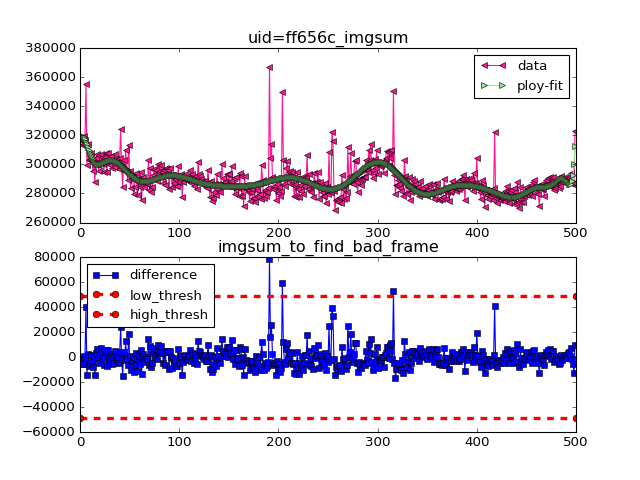

The bad frame list length is: 3


In [6566]:
bad_frame_list =  get_bad_frame_list( imgsum, fit=True, plot=True,polyfit_order = 30, 
                        scale= 5.5,  good_start = good_start, good_end=good_end, uid= uidstr, path=data_dir)

print( 'The bad frame list length is: %s'%len(bad_frame_list) )

#### For beamline to find the bad pixels

In [6567]:
#bp = find_bad_pixels( FD, bad_frame_list, md['uid'] )
#bp.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )

### Creat new mask by masking the bad pixels and get new avg_img

In [6568]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'],
           filename=uidstr + '_img_sum_t', path= data_dir  )


### Plot time~ total intensity of each frame

<IPython.core.display.Javascript object>


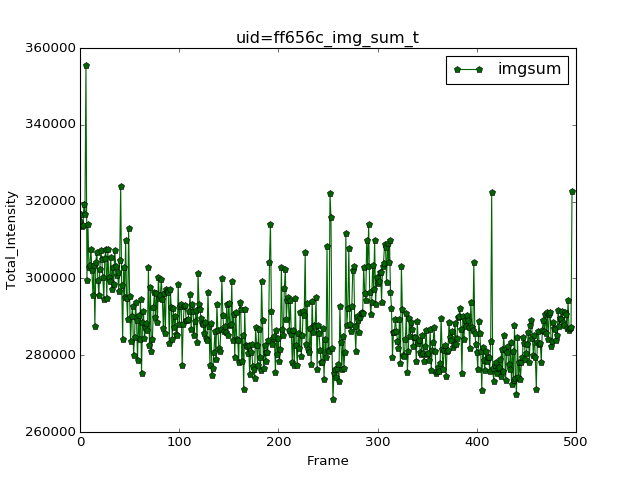

In [6569]:
plot1D( y = imgsum_y, title = uidstr + '_img_sum_t', xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

### Plot intensity average image

<IPython.core.display.Javascript object>


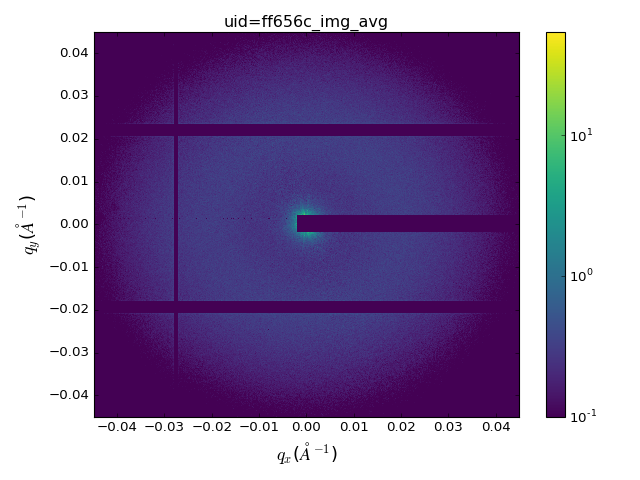

In [6570]:
if scat_geometry =='saxs':
    show_saxs_qmap( avg_img, setup_pargs, width=600,vmin=.1, vmax=np.max(avg_img*1), logs=True,
       image_name= uidstr + '_img_avg',  save=True) 
elif scat_geometry =='gi_saxs':    
    show_img( avg_img,  vmin=.1, vmax=np.max(avg_img*.1), logs=True,
         image_name= uidstr + '_img_avg',  save=True, path=data_dir) 

# Static Analysis

## SAXS Scattering Geometry

<IPython.core.display.Javascript object>


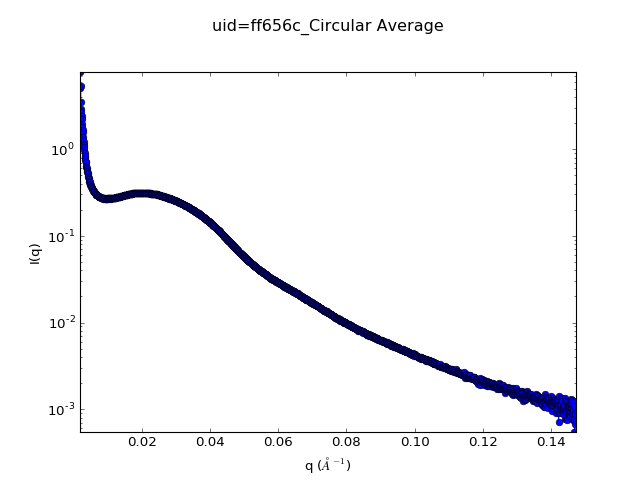

In [6571]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 400)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                      xlim=[q_saxs.min(), q_saxs.max()], ylim = [iq_saxs.min(), iq_saxs.max()] )
    
    pd = trans_data_to_pd( np.where( hmask !=1), 
            label=[md['uid']+'_hmask'+'x', md['uid']+'_hmask'+'y' ], dtype='list')
    pd.to_csv('/XF11ID/analysis/2017_1/manisen/eiger4M_badpixel.csv', mode='a'  )
    mask =np.array( mask * hmask, dtype=bool) 
    #show_img( mask )
    
    #### WHY this explicit path here???

In [6572]:
if scat_geometry =='saxs':
    if run_fit_form:        
        form_res = fit_form_factor( q_saxs,iq_saxs,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])  

In [6573]:
if scat_geometry =='saxs':    
    uniformq = True #False    
    ## Define ROI
    #* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
    #* Create ring mask defined by  edges (all in pixel unit)    
    ### Define a non-uniform distributed rings by giving edges
    if not uniformq:    
        width = 0.0002    
        number_rings= 1    
        qcenters = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
        edges = get_non_uniform_edges(  qcenters, width, number_rings )    
        inner_radius= None
        outer_radius = None
        width = None
        num_rings = None        
    # Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)
    if uniformq:    
        inner_radius= 0.005 #0.006  #16
        outer_radius = 0.06 #0.05  #112    
        num_rings = 18
        gap_ring_number = 6
        width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
        edges = None

<IPython.core.display.Javascript object>


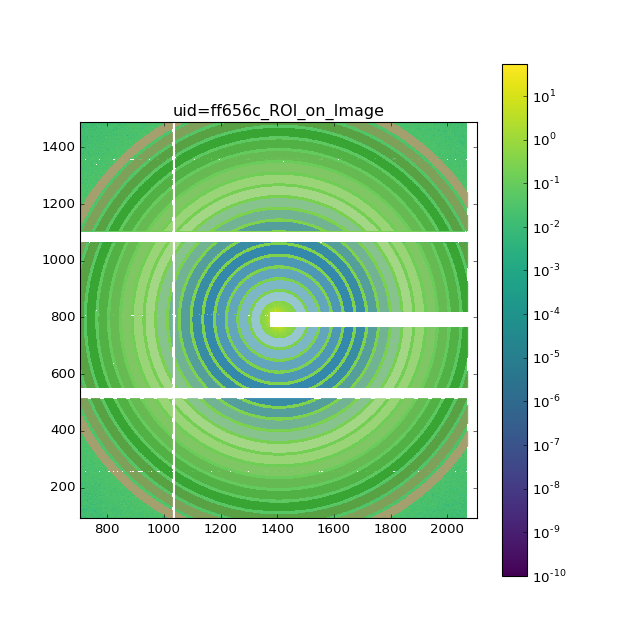

In [6574]:
if scat_geometry =='saxs':
    roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
    qr = np.round( qr, 4)
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth =700, alpha=.9,  
                     save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 
    qval_dict = get_qval_dict( np.round(qr, 4)  ) 

<IPython.core.display.Javascript object>


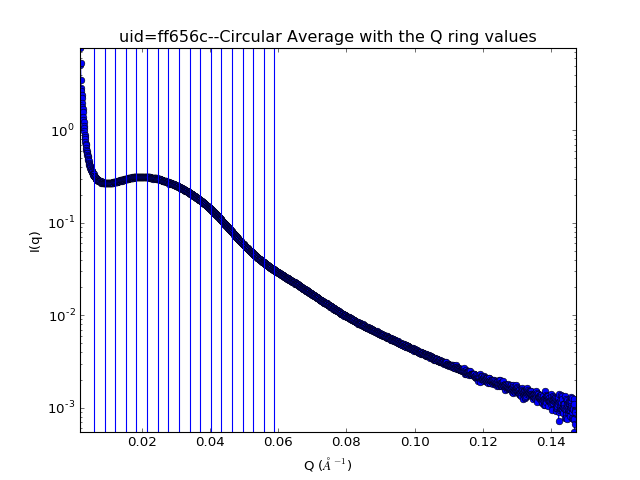

In [6575]:
if scat_geometry =='saxs':
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=[q_saxs.min(), q_saxs.max()],
                  ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)

## Static Analysis for saxs

Averaging 1 images: 100%|██████████| 1/1 [00:00<00:00, 327.30it/s]

[[  0   1]
 [249 250]
 [499 500]]



Averaging 1 images: 100%|██████████| 1/1 [00:00<00:00, 46.32it/s]


<IPython.core.display.Javascript object>


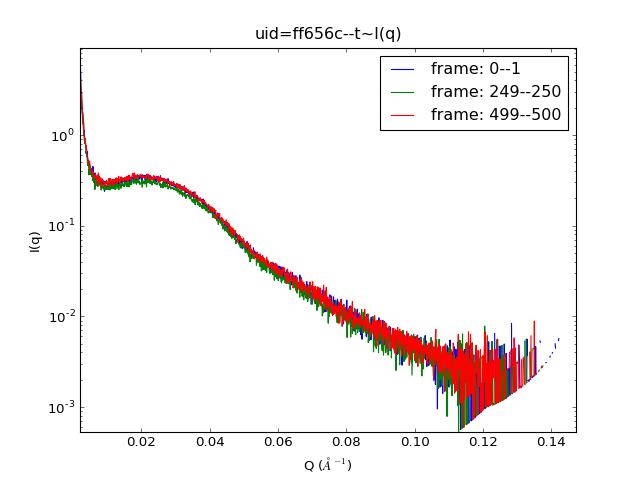

The file: uid=ff656c_q_Iqt is saved in /XF11ID/analysis/2017_1/manisen/Results/ff656c/


In [6576]:
if scat_geometry =='saxs':
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 1, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    print( time_edge )
    
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500 )
    plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

# GiSAXS Scattering Geometry

In [6577]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users put incident-Beam and Reflection_Beam Centers here!!!
    # Change these lines
    inc_x0 = 1572 - 3
    inc_y0 = 64

    refl_x0 = 1572 
    refl_y0 = 452
    
    # Don't Change these lines below here
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )

## Static Analysis for gisaxs

In [6578]:
if scat_geometry =='gi_saxs':
    # For diffuse near Yoneda wing
    qz_start = 0.034
    qz_end = 0.039
    qz_num= 1
    qz_width = 0.005

    qr_start =  0.002
    qr_end = 0.08
    qr_num = 1
    qr_width = 0.08 - 0.002


    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )

    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )

In [6579]:
if  scat_geometry =='gi_saxs':    
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( N= Nimg, slice_num= 10, slice_width= 2, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    print( time_edge )    
    qrt_pds = get_t_qrc( FD, time_edge, Qr, Qz, qr_map, qz_map, path=data_dir, uid = uidstr )    
    plot_qrt_pds( qrt_pds, time_edge, qz_index = 0, uid = uidstr, path =  data_dir )

# Make a Profile Plot

In [6580]:
if  scat_geometry =='gi_saxs':
    #img_index = 0
    #show_img(  imgs[img_index] +1, xlim = [1330,1810], ylim=[2167-2150, 2167-1200],  vmin=1, vmax=50, logs=True,
    #    image_name= uidstr + '_frame_%s'%img_index)
    
    xcorners= [ 1330, 1810, 1810, 1330 ]
    ycorners= [ 312, 312, 362, 362 ]
    waterfall_roi_size = [ xcorners[1] - xcorners[0],  ycorners[2] - ycorners[1]  ]
    waterfall_roi =  create_rectangle_mask(  avg_img, xcorners, ycorners   )
    #show_img( waterful_roi * avg_img, xlim = [1330,1810], ylim=[212, 462], aspect=1,vmin=1, vmax=50, logs=True, )
    
    wat = cal_waterfallc( FD, waterfall_roi, qindex= 1, bin_waterfall=True,
                          waterfall_roi_size = waterfall_roi_size,save =True, path=data_dir, uid=uidstr)
    

In [6581]:
if  scat_geometry =='gi_saxs':
    plot_waterfallc( wat, qindex=1, aspect=None, vmin=1, vmax= np.max( wat), uid=uidstr, save =True, 
                        path=data_dir, beg= FD.beg)

## Dynamic Analysis for gi_saxs

In [6582]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines

    qz_start = 0.037
    qz_end = 0.065 + 0.002 #0.050 + 0.0015
    qz_num= 3
    gap_qz_num = 1    
    qz_width =  0.002 #(qz_end - qz_start)/(qz_num +gap_qz_num)
    
    qr_start =   0.008
    qr_end = 0.048 + 0.008
    qr_num = 16
    gap_qr_num = 5
    qr_width = 0.003 #( qr_end- qr_start)/(qr_num+gap_qr_num)

    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )



In [6583]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = True #False  #if True to define another line; else: make it False
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.044
        qz_end2 = 0.05
        qz_num2= 1
        gap_qz_num2 = 1
        qz_width2 = 0.005 #(qz_end2 - qz_start2)/(qz_num2 +gap_qz_num2)    
        
        qr_start2 =  -0.003
        qr_end2 = 0.003
        qr_num2 = 1
        gap_qr_num2 = 5
        qr_width2 = 0.006 #( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)        
        
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )        
        show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )        
        ## Get 1D Curve (Q||-intensity¶)
        qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0= None, setup_pargs=setup_pargs )
        plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)

* Extract the labeled array

In [6584]:
qind, pixelist = roi.extract_label_indices(roi_mask)
noqs = len(np.unique(qind))

* Number of pixels in each q box

In [6585]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([ 14125,  22065,  30032,  38027,  42703,  42511,  53043,  60537,
        70205,  79434,  87208,  95380, 103269, 111451, 118215, 115274,
       118393, 119355])

## Check one ROI intensity

<IPython.core.display.Javascript object>


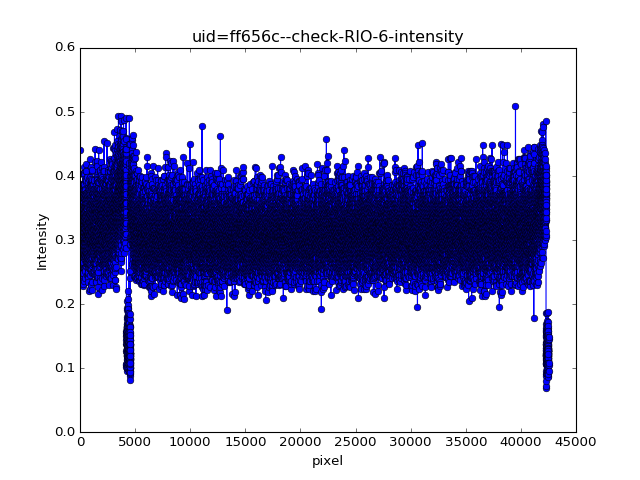

In [6586]:
roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qth_interest, uid =uidstr )

## Do a waterfall analysis

In [6587]:
if scat_geometry =='saxs':
    if run_waterfall:    
        wat = cal_waterfallc( FD, roi_mask, qindex= qth_interest, save =True, path=data_dir, uid=uidstr)

In [6588]:
if scat_geometry =='saxs':
    if run_waterfall: 
        plot_waterfallc( wat, qth_interest, aspect=None, 
                        vmax= np.max(wat), uid=uidstr, save =True, 
                        path=data_dir, beg= FD.beg)

Get ROI intensity of each frame: 100%|██████████| 500/500 [00:02<00:00, 181.29it/s]


<IPython.core.display.Javascript object>


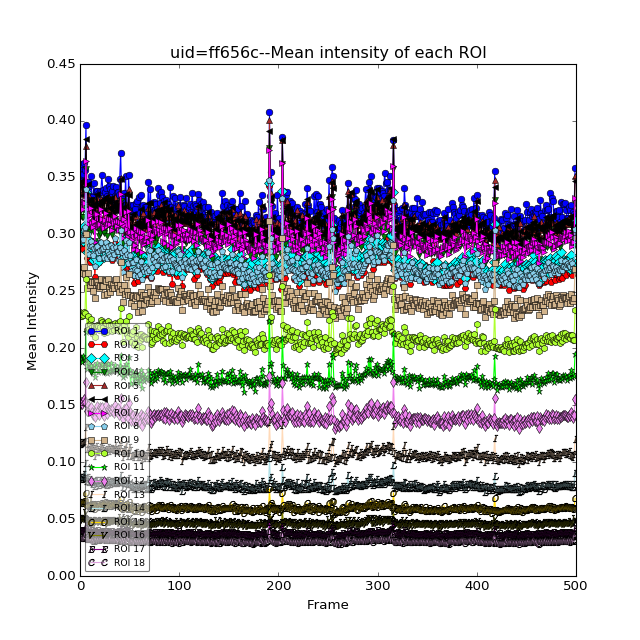

The file: uid=ff656c_t_ROIs is saved in /XF11ID/analysis/2017_1/manisen/Results/ff656c/


In [6589]:
ring_avg = None    
if run_t_ROI_Inten:
    times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None,  ) 
    plot_each_ring_mean_intensityc( times_roi, mean_int_sets,  uid = uidstr, save=True, path=data_dir )
    roi_avg = np.average( mean_int_sets, axis=0)
    

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [6590]:
define_good_series = False   #False 
if define_good_series:
    good_start = 300
    FD = Multifile(filename, beg = good_start, end = Nimg)
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )

In [6591]:
lag_steps = None
if use_sqnorm:
    norm = get_pixelist_interp_iq( qp_saxs, iq_saxs, roi_mask, center)
else:
    norm=None 
if use_imgsum_norm:
    imgsum_ = imgsum
else:
    imgsum_ = None     

In [6592]:
if run_one_time: 
    t0 = time.time()    
    g2, lag_steps  = cal_g2p( FD,  roi_mask, bad_frame_list,good_start, num_buf = 8, num_lev= None,
                            imgsum= imgsum_, norm=norm )
    run_time(t0)
    

In this g2 calculation, the buf and lev number are: 8--8--
Bad frame involved and will be precessed!
498 frames will be processed...


  0%|          | 0/18 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/18 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 18/18 [00:13<00:00,  1.79it/s]

G2 calculation DONE!
Total time: 0.33 min


In [6593]:
if run_one_time: 
    taus = lag_steps * timeperframe    
    g2_pds = save_g2_general( g2, taus=taus,qr=np.array( list( qval_dict.values() ) )[:,0],
                             uid=uid_+'_g2.csv', path= data_dir, return_res=True )

The correlation function is saved in /XF11ID/analysis/2017_1/manisen/Results/ff656c/ with filename as uid=ff656c_fra_0_500_g2.csv


### Plot the one time correlation functions

In [6594]:
#if run_one_time:
#    plot_g2_general( g2_dict={1:g2}, taus_dict={1:taus},vlim=[0.95, 1.05], qval_dict = qval_dict, fit_res= None, 
#                geometry=scat_geometry,filename=uid_+'_g2',path= data_dir,   ylabel='g2')

# Fit g2

In [6595]:
if run_one_time:
    g2_fit_result, taus_fit, g2_fit = get_g2_fit_general( g2,  taus, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':False, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
    g2_fit_paras = save_g2_fit_para_tocsv(g2_fit_result,  filename= uid_  +'_g2_fit_paras.csv', path=data_dir ) 
    

The g2 fitting parameters are saved in /XF11ID/analysis/2017_1/manisen/Results/ff656c/uid=ff656c_fra_0_500_g2_fit_paras.csv


<IPython.core.display.Javascript object>


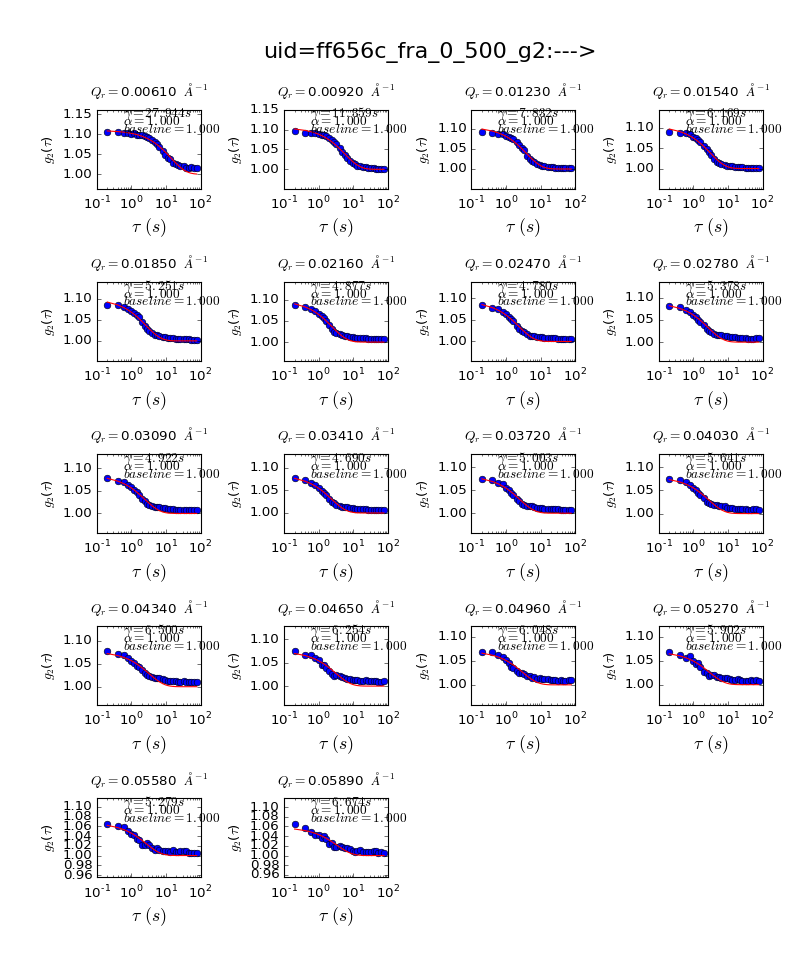

In [6596]:
if run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2_fit}, taus_dict={1:taus, 2:taus_fit},vlim=[0.95, 1.05],
                qval_dict = qval_dict, fit_res= g2_fit_result,  geometry=scat_geometry,filename= uid_+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_fit')

The fitted diffusion coefficient D0 is:  7.949e+01   A^2S-1


<IPython.core.display.Javascript object>


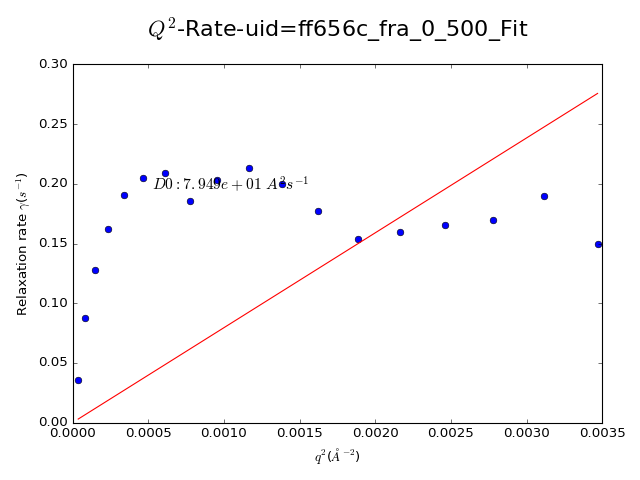

In [6597]:
if run_one_time:
    D0, qrate_fit_res = get_q_rate_fit_general(  qval_dict, g2_fit_paras['relaxation_rate'], geometry= scat_geometry )
    plot_q_rate_fit_general( qval_dict, g2_fit_paras['relaxation_rate'],  qrate_fit_res, 
                            geometry= scat_geometry,uid=uid_  , path= data_dir )

# For two-time

In [6598]:
data_pixel = None
if run_two_time:    
    data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm= norm ).get_data()

100%|██████████| 500/500 [00:04<00:00, 115.56it/s]


In [6599]:
t0=time.time()
g12b=None
if run_two_time:     
    g12b = auto_two_Arrayc(  data_pixel,  roi_mask, index = None   )
run_time( t0 )        

100%|██████████| 18/18 [00:09<00:00,  1.26it/s]

Total time: 0.16 min


<IPython.core.display.Javascript object>


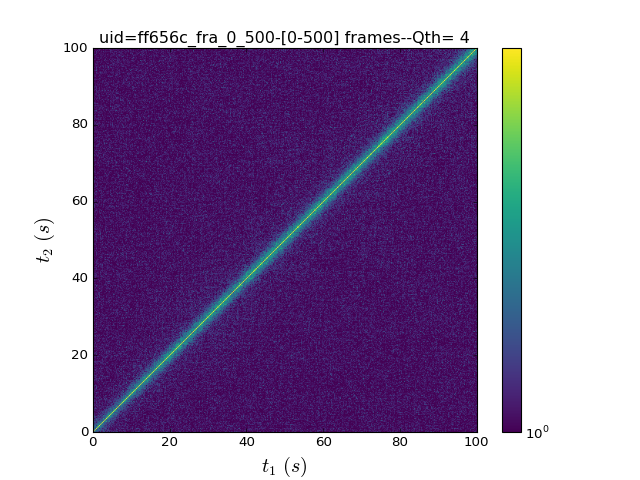

In [6600]:
if run_two_time:
    show_C12(g12b, q_ind= 4, N1= FD.beg, N2=min( FD.end,5000), vmin=1.0, vmax=1.18,
             timeperframe=timeperframe,save=True, path= data_dir, uid = uid_ )    

In [6601]:
if run_two_time:
    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    #max_taus= lag_steps.max()  
    max_taus = Nimg    
    t0=time.time()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    run_time(t0)
    tausb = np.arange( g2b.shape[0])[:max_taus] *timeperframe     
    g2b_pds = save_g2_general( g2b, taus=tausb, qr= np.array( list( qval_dict.values() ) )[:,0],
                              qz=None, uid=uid_ +'_g2b.csv', path= data_dir, return_res=True )
    

Total time: 0.00 min
The correlation function is saved in /XF11ID/analysis/2017_1/manisen/Results/ff656c/ with filename as uid=ff656c_fra_0_500_g2b.csv


In [6602]:
if run_two_time:
    g2_fit_resultb, taus_fitb, g2_fitb = get_g2_fit_general( g2b,  tausb, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
                guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
    
    g2b_fit_paras = save_g2_fit_para_tocsv(g2_fit_resultb, 
                    filename= '%s'%uid_  + '_g2b_fit_paras.csv', path=data_dir )

The g2 fitting parameters are saved in /XF11ID/analysis/2017_1/manisen/Results/ff656c/uid=ff656c_fra_0_500_g2b_fit_paras.csv


<IPython.core.display.Javascript object>


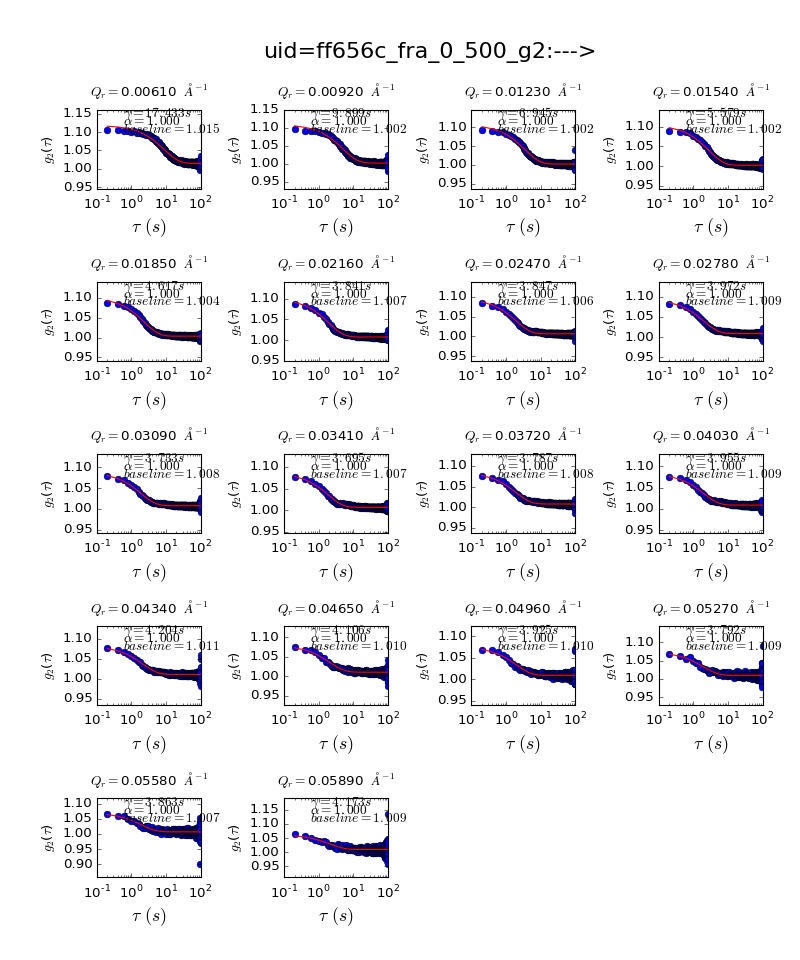

In [6603]:
if run_two_time:
    plot_g2_general( g2_dict={1:g2b, 2:g2_fitb}, taus_dict={1:tausb, 2:taus_fitb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, fit_res= g2_fit_resultb,  geometry=scat_geometry,filename=uid_+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_b_fit')

<IPython.core.display.Javascript object>


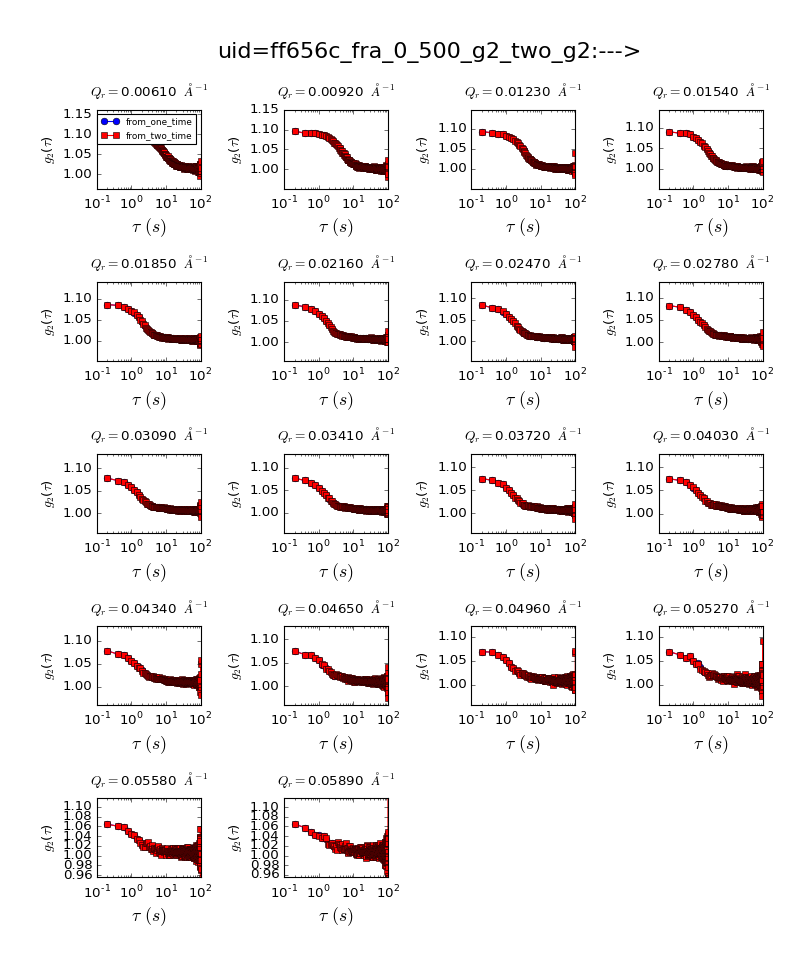

In [6604]:
if run_two_time and run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2b}, taus_dict={1:taus, 2:tausb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, g2_labels=['from_one_time', 'from_two_time'],
            geometry=scat_geometry,filename=uid_+'_g2_two_g2', path= data_dir, ylabel='g2', )

# Four Time Correlation

In [6605]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

Total time: 0.00 min


In [6606]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe        
    g4_pds = save_g2_general( g4, taus=taus4, qr=np.array( list( qval_dict.values() ) )[:,0],
                             qz=None, uid=uid_ +'_g4.csv', path= data_dir, return_res=True )
     


The correlation function is saved in /XF11ID/analysis/2017_1/manisen/Results/ff656c/ with filename as uid=ff656c_fra_0_500_g4.csv


<IPython.core.display.Javascript object>


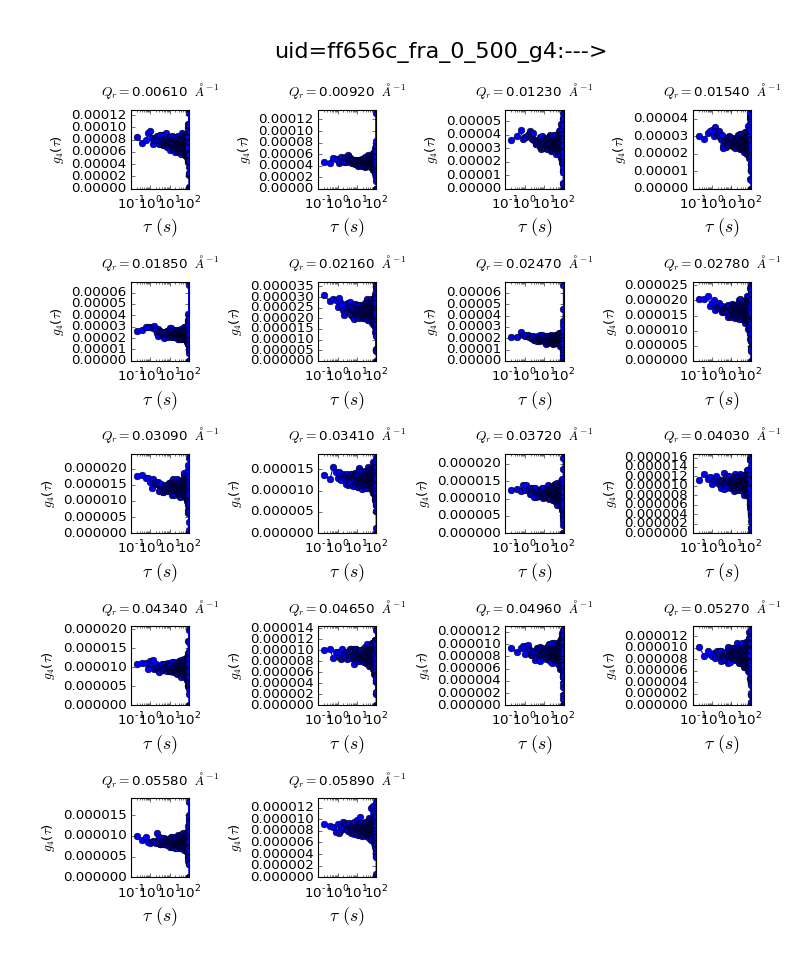

In [6607]:
if run_four_time:
    plot_g2_general( g2_dict={1:g4}, taus_dict={1:taus4},vlim=[0.95, 1.05], qval_dict=qval_dict, fit_res= None, 
                geometry=scat_geometry,filename=uid_+'_g4',path= data_dir,   ylabel='g4')

# Speckle Visiblity

In [6608]:
if run_xsvs:    
    max_cts = get_max_countc(FD, roi_mask )
    qind, pixelist = roi.extract_label_indices(   roi_mask  )
    noqs = len( np.unique(qind) )
    nopr = np.bincount(qind, minlength=(noqs+1))[1:]
    #time_steps = np.array( utils.geometric_series(2,   len(imgs)   ) )
    time_steps = [0,1]  #only run the first two levels
    num_times = len(time_steps)    
    times_xsvs = exposuretime + (2**(  np.arange( len(time_steps) ) ) -1 ) * acquisition_period    
    print( 'The max counts are: %s'%max_cts )


### Do historam 

In [6609]:
if run_xsvs:
    if roi_avg is  None:
        times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None,  ) 
        roi_avg = np.average( mean_int_sets, axis=0)
    
    t0=time.time()
    spec_bins, spec_his, spec_std  =  xsvsp( FD, np.int_(roi_mask), norm=None,
                max_cts=int(max_cts+2),  bad_images=bad_frame_list, only_two_levels=True )    
    spec_kmean =  np.array(  [roi_avg * 2**j for j in  range( spec_his.shape[0] )] )
    run_time(t0)
    spec_pds =  save_bin_his_std( spec_bins, spec_his, spec_std, filename=uid_+'_spec_res.csv', path=data_dir ) 

### Do historam fit by negtive binominal function with maximum likehood method

In [6610]:
if run_xsvs:    
    ML_val, KL_val,K_ = get_xsvs_fit(  spec_his, spec_kmean,  spec_std, max_bins=2,varyK= False, )
    #print( 'The observed average photon counts are: %s'%np.round(K_mean,4))
    #print( 'The fitted average photon counts are: %s'%np.round(K_,4)) 
    print( 'The difference sum of average photon counts between fit and data are: %s'%np.round( 
            abs(np.sum( spec_kmean[0,:] - K_ )),4))
    print( '#'*30)
    qth=   10 
    print( 'The fitted M for Qth= %s are: %s'%(qth, ML_val[qth]) )
    print( K_[qth])
    print( '#'*30)

## Plot fit results

In [6611]:
if run_xsvs:   
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std=spec_std,
                  xlim = [0,10], vlim =[.9, 1.1],
        uid=uid_, qth= qth_interest, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir)
    
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std = spec_std,
                  xlim = [0,15], vlim =[.9, 1.1],
        uid=uid_, qth= None, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir )

### Get contrast

In [6612]:
if run_xsvs:
    contrast_factorL = get_contrast( ML_val)
    spec_km_pds = save_KM(  spec_kmean, KL_val, ML_val, qs=qr, level_time=times_xsvs, uid=uid_, path = data_dir )
    #spec_km_pds

### Plot contrast with g2 restuls

In [6613]:
if run_xsvs:    
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,1.2], qth = qth_interest, uid=uid_,path = data_dir, legend_size=14)

    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,1.2], qth = None, uid=uid_,path = data_dir, legend_size=4)

# Export Results to a HDF5 File

In [6614]:
md['mask_file']= mask_path + mask_name
md['mask'] = mask
md['NOTEBOOK_FULL_PATH'] = None
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list
md['avg_img'] = avg_img
md['roi_mask'] = roi_mask

if scat_geometry == 'gi_saxs':        
    md['Qr'] = Qr
    md['Qz'] = Qz
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  inc_x0
    md['beam_center_y']=   inc_y0
    md['beam_refl_center_x'] = refl_x0
    md['beam_refl_center_y'] = refl_y0

else:
    md['qr']= qr
    md['qr_edge'] = qr_edge
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  center[1]
    md['beam_center_y']=  center[0]            

md['beg'] = FD.beg
md['end'] = FD.end
md['metadata_file'] = data_dir + 'md.csv-&-md.pkl'
psave_obj(  md, data_dir + 'uid=%s_md'%uid ) #save the setup parameters
save_dict_csv( md,  data_dir + 'uid=%s_md.csv'%uid, 'w')

Exdt = {} 
if scat_geometry == 'gi_saxs':  
    for k,v in zip( ['md', 'roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list', 'qr_1d_pds'], 
                [md,    roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list, qr_1d_pds] ):
        Exdt[ k ] = v
elif scat_geometry == 'saxs': 
    for k,v in zip( ['md', 'q_saxs', 'iq_saxs','iqst','qt','roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list'], 
                [md, q_saxs, iq_saxs, iqst, qt,roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list] ):
        Exdt[ k ] = v

if run_waterfall:Exdt['wat'] =  wat
if run_t_ROI_Inten:Exdt['times_roi'] = times_roi;Exdt['mean_int_sets']=mean_int_sets
if run_one_time:
    for k,v in zip( ['taus','g2','g2_fit_paras'], [taus,g2,g2_fit_paras] ):Exdt[ k ] = v
if run_two_time:
    for k,v in zip( ['tausb','g2b','g2b_fit_paras', 'g12b'], [tausb,g2b,g2b_fit_paras,g12b] ):Exdt[ k ] = v
if run_four_time:
    for k,v in zip( ['taus4','g4'], [taus4,g4] ):Exdt[ k ] = v
if run_xsvs:
    for k,v in zip( ['spec_kmean','spec_pds','times_xsvs','spec_km_pds','contrast_factorL'], 
                   [ spec_kmean,spec_pds,times_xsvs,spec_km_pds,contrast_factorL] ):Exdt[ k ] = v 

In [6615]:
export_xpcs_results_to_h5( 'uid=%s_Res.h5'%md['uid'], data_dir, export_dict = Exdt )
#extract_dict = extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%md['uid'], import_dir = data_dir )

The xpcs analysis results are exported to /XF11ID/analysis/2017_1/manisen/Results/ff656c/ with filename as uid=ff656c1f-5aa3-4dcb-8489-e1809933ff1e_Res.h5


# Creat PDF Report

In [6616]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
pdf_filename = "XPCS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)

In [6617]:
make_pdf_report( data_dir, uid, pdf_out_dir, pdf_filename, username, 
                    run_fit_form,run_one_time, run_two_time, run_four_time, run_xsvs, report_type= scat_geometry
                   )

uid=ff656c_ROI_on_Iq.png

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2017_1/manisen/Results/XPCS_Analysis_Report_for_uid=ff656c_1.pdf
****************************************


## Attach the PDF report to Olog 

In [6618]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname = pdf_out_dir + pdf_filename 
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= md['uid'], text='Add XPCS Analysis PDF Report', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add XPCS Analysis PDF Report and with the attachments


# The End!

In [6619]:

uid

'ff656c'

# 